In [12]:
# jointgrid gives a handy way to put marginal axis on each side of the pitch.

In [13]:
!pip install mplsoccer statsbombpy
from mplsoccer import Sbopen, Pitch, VerticalPitch, FontManager
import statsbombpy
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colormaps
import matplotlib.pyplot as plt

In [14]:
parser = Sbopen()
df, related, freeze, tactics = parser.event(3943043)

# setup the mplsoccer StatsBomb Pitches
# note not much padding around the pitch so the marginal axis are tight to the pitch
# if you are using a different goal type you will need to increase the padding to see the goals
pitch = Pitch(pad_top=0.05, pad_right=0.05, pad_bottom=0.05, pad_left=0.05, line_zorder=2)
vertical_pitch = VerticalPitch(half=True, pad_top=0.05, pad_right=0.05, pad_bottom=0.05,
                               pad_left=0.05, line_zorder=2)

# setup a mplsoccer FontManager to download google fonts (Roboto-Regular / SigmarOne-Regular)
fm = FontManager()
fm_rubik = FontManager('https://raw.githubusercontent.com/google/fonts/main/ofl/rubikmonoone/'
                       'RubikMonoOne-Regular.ttf')

In [15]:
# subset the shots
df_shots = df[df.type_name == 'Shot'].copy()

# subset the shots for each team
team1, team2 = df_shots.team_name.unique()
df_team1 = df_shots[df_shots.team_name == team1].copy()
df_team2 = df_shots[df_shots.team_name == team2].copy()

# Usually in football, the data is collected so the attacking direction is left to right.
# We can shift the coordinates via: new_x_coordinate = right_side - old_x_coordinate
# This is helpful for having one team shots on the left of the pitch and the other on the right
df_team1['x'] = pitch.dim.right - df_team1.x

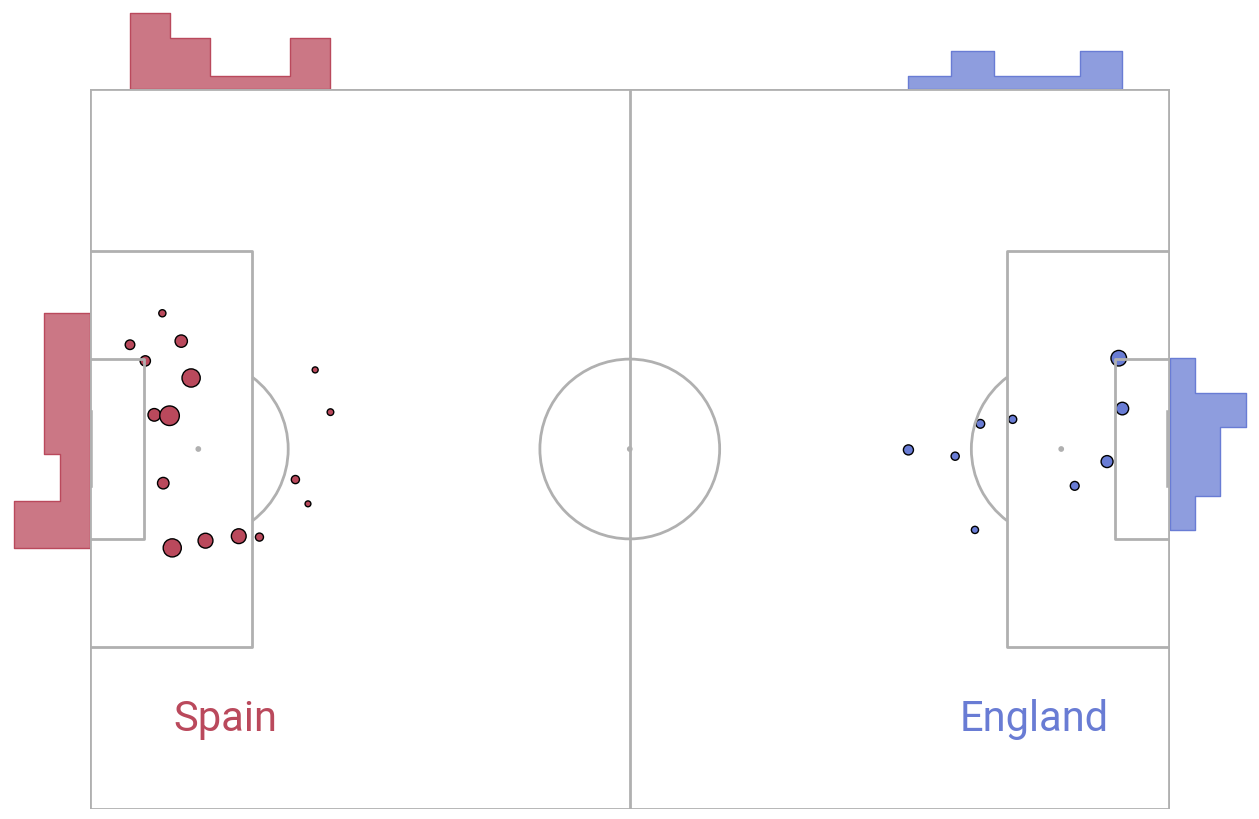

In [16]:
fig, axs = pitch.jointgrid(figheight=10,  # the figure is 10 inches high
                           left=None,  # joint grid center-aligned
                           bottom=0.075,  # grid starts 7.5% in from the bottom of the figure
                           marginal=0.1,  # marginal axes heights are 10% of grid height
                           space=0,  # 0% of the grid height reserved for space between axes
                           grid_width=0.9,  # the grid width takes up 90% of the figure width
                           title_height=0,  # plot without a title axes
                           axis=False,  # turn off title/ endnote/ marginal axes
                           endnote_height=0,  # plot without an endnote axes
                           grid_height=0.8)  # grid takes up 80% of the figure height
# we plot a usual scatter plot but the scatter size is based on expected goals
# note that the size is the expected goals * 700
# so any shots with an expected goals = 1 would take a size of 700 (points**2)
sc_team1 = pitch.scatter(df_team1.x, df_team1.y, s=df_team1.shot_statsbomb_xg * 700,
                         ec='black', color='#ba495c', ax=axs['pitch'])
sc_team2 = pitch.scatter(df_team2.x, df_team2.y, s=df_team2.shot_statsbomb_xg * 700,
                         ec='black', color='#697cd4', ax=axs['pitch'])
# (step) histograms on each of the left, top, and right marginal axes
team1_hist_y = sns.histplot(y=df_team1.y, ax=axs['left'], element='step', color='#ba495c')
team1_hist_x = sns.histplot(x=df_team1.x, ax=axs['top'], element='step', color='#ba495c')
team2_hist_x = sns.histplot(x=df_team2.x, ax=axs['top'], element='step', color='#697cd4')
team2_hist_y = sns.histplot(y=df_team2.y, ax=axs['right'], element='step', color='#697cd4')
txt1 = axs['pitch'].text(x=15, y=70, s=team1, fontproperties=fm.prop, color='#ba495c',
                         ha='center', va='center', fontsize=30)
txt2 = axs['pitch'].text(x=105, y=70, s=team2, fontproperties=fm.prop, color='#697cd4',
                         ha='center', va='center', fontsize=30)

In [17]:
#Get colors use for charts
red = colormaps.get_cmap('Reds')(np.linspace(0, 1, 100))[60]
blue = colormaps.get_cmap('Blues')(np.linspace(0, 1, 100))[60]

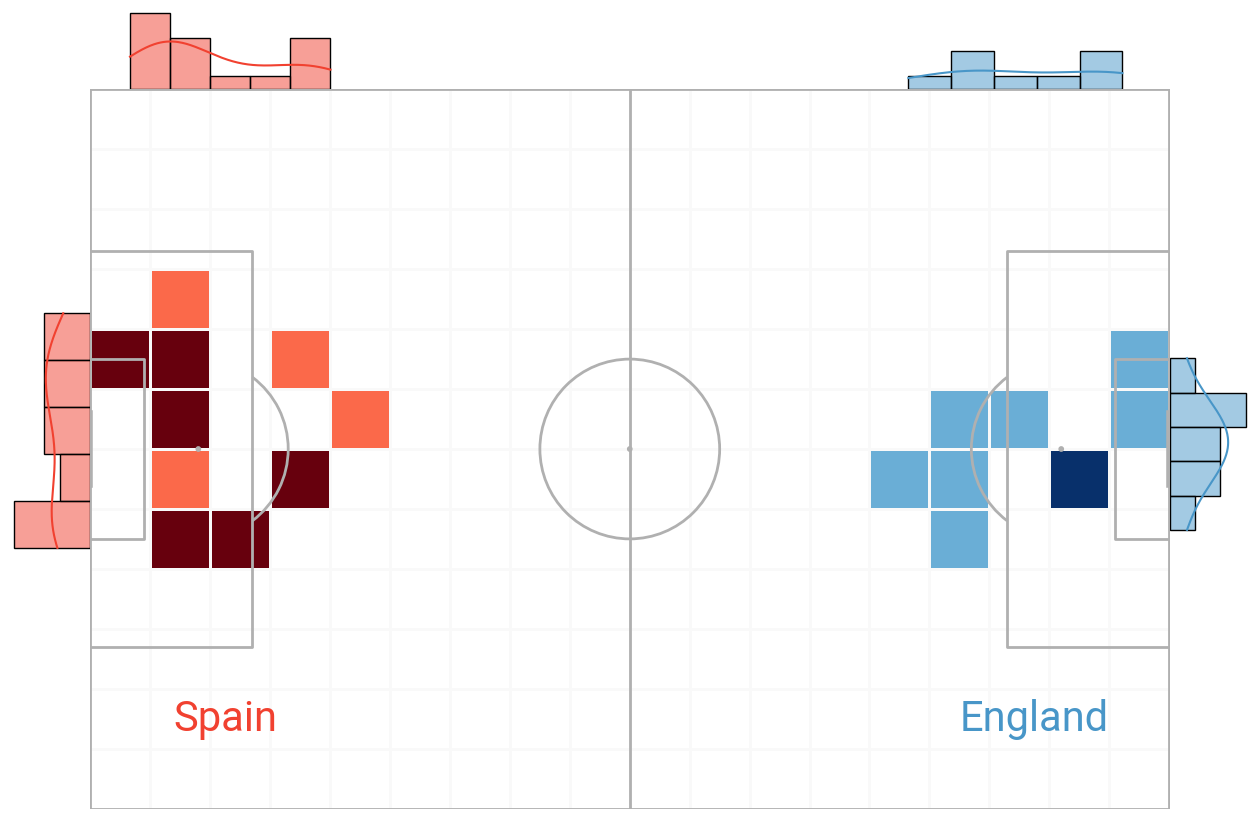

In [18]:
#Heatmap shot map with histogram/ kdeplot on the marginal axes

fig, axs = pitch.jointgrid(figheight=10, left=None, bottom=0.075, grid_height=0.8,
                           axis=False,  # turn off title/ endnote/ marginal axes
                           # plot without endnote/ title axes
                           title_height=0, endnote_height=0)
bs1 = pitch.bin_statistic(df_team1.x, df_team1.y, bins=(18, 12))
bs2 = pitch.bin_statistic(df_team2.x, df_team2.y, bins=(18, 12))
# get the min/ max values for normalizing across both teams
vmax = max(bs2['statistic'].max(), bs1['statistic'].max())
vmin = max(bs2['statistic'].min(), bs1['statistic'].min())
# set values where zero shots to nan values so it does not show up in the heatmap
# i.e. zero values take the background color
bs1['statistic'][bs1['statistic'] == 0] = np.nan
bs2['statistic'][bs2['statistic'] == 0] = np.nan
# set the vmin/ vmax so the colors depend on the minimum/maximum value for both teams
hm1 = pitch.heatmap(bs1, ax=axs['pitch'], cmap='Reds', vmin=vmin, vmax=vmax, edgecolor='#f9f9f9')
hm2 = pitch.heatmap(bs2, ax=axs['pitch'], cmap='Blues', vmin=vmin, vmax=vmax, edgecolor='#f9f9f9')
# histograms with kdeplot
team1_hist_y = sns.histplot(y=df_team1.y, ax=axs['left'], color=red, linewidth=1, kde=True)
team1_hist_x = sns.histplot(x=df_team1.x, ax=axs['top'], color=red, linewidth=1, kde=True)
team2_hist_x = sns.histplot(x=df_team2.x, ax=axs['top'], color=blue, linewidth=1, kde=True)
team2_hist_y = sns.histplot(y=df_team2.y, ax=axs['right'], color=blue, linewidth=1, kde=True)
txt1 = axs['pitch'].text(x=15, y=70, s=team1, fontproperties=fm.prop, color=red,
                         ha='center', va='center', fontsize=30)
txt2 = axs['pitch'].text(x=105, y=70, s=team2, fontproperties=fm.prop, color=blue,
                         ha='center', va='center', fontsize=30)

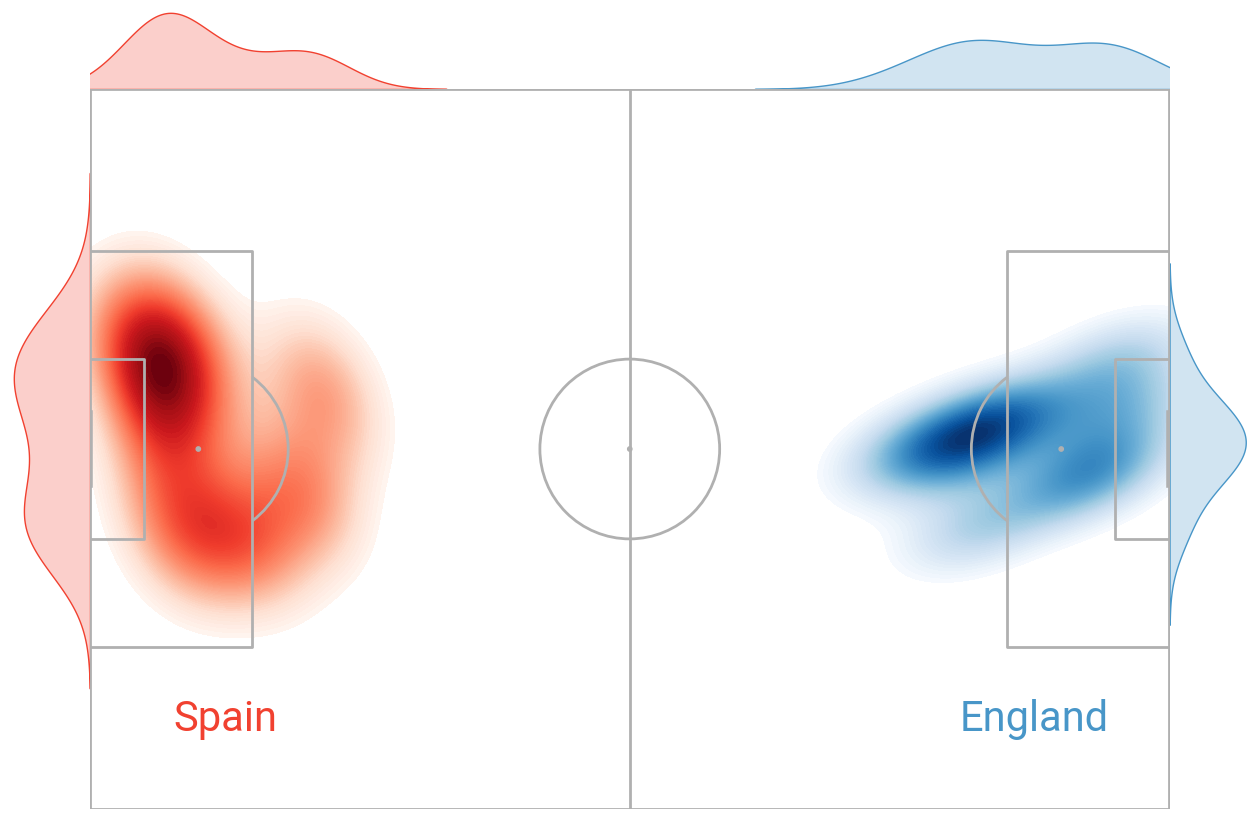

In [19]:
# Kdeplot shot map with kdeplot on the marginal axes

fig, axs = pitch.jointgrid(figheight=10, left=None, bottom=0.075, grid_height=0.8,
                           axis=False,  # turn off title/ endnote/ marginal axes
                           # plot without endnote/ title axes
                           title_height=0, endnote_height=0)
# increase number of levels for a smoother looking heatmap
kde1 = pitch.kdeplot(df_team1.x, df_team1.y, ax=axs['pitch'], cmap='Reds', levels=75, fill=True)
kde2 = pitch.kdeplot(df_team2.x, df_team2.y, ax=axs['pitch'], cmap='Blues', levels=75, fill=True)
# kdeplot on marginal axes
team1_hist_y = sns.kdeplot(y=df_team1.y, ax=axs['left'], color=red, fill=True)
team1_hist_x = sns.kdeplot(x=df_team1.x, ax=axs['top'], color=red, fill=True)
team2_hist_x = sns.kdeplot(x=df_team2.x, ax=axs['top'], color=blue, fill=True)
team2_hist_y = sns.kdeplot(y=df_team2.y, ax=axs['right'], color=blue, fill=True)
txt1 = axs['pitch'].text(x=15, y=70, s=team1, fontproperties=fm.prop, color=red,
                         ha='center', va='center', fontsize=30)
txt2 = axs['pitch'].text(x=105, y=70, s=team2, fontproperties=fm.prop, color=blue,
                         ha='center', va='center', fontsize=30)